In [165]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [166]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date')

In [167]:
df.index.dtype

dtype('<M8[ns]')

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

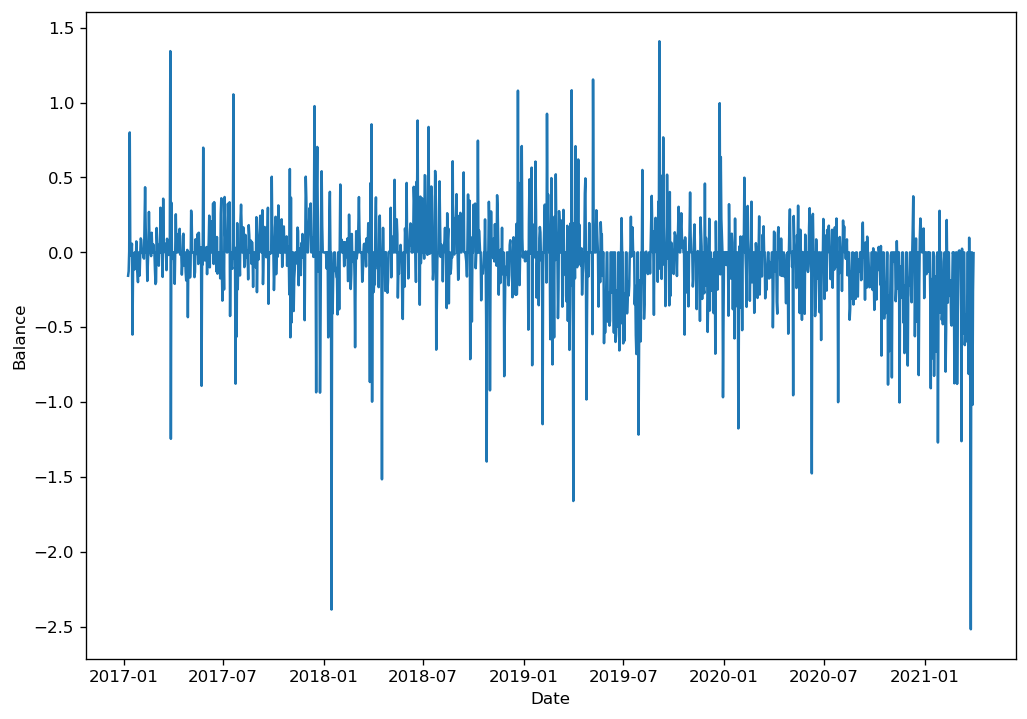

In [168]:
sns.lineplot(x = df.index, y = df.Balance)


# Тест Дики-Фуллера для проверки на стационарность

In [169]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [170]:
adf_test(df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [171]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [172]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Разложение на компоненты (попытка)

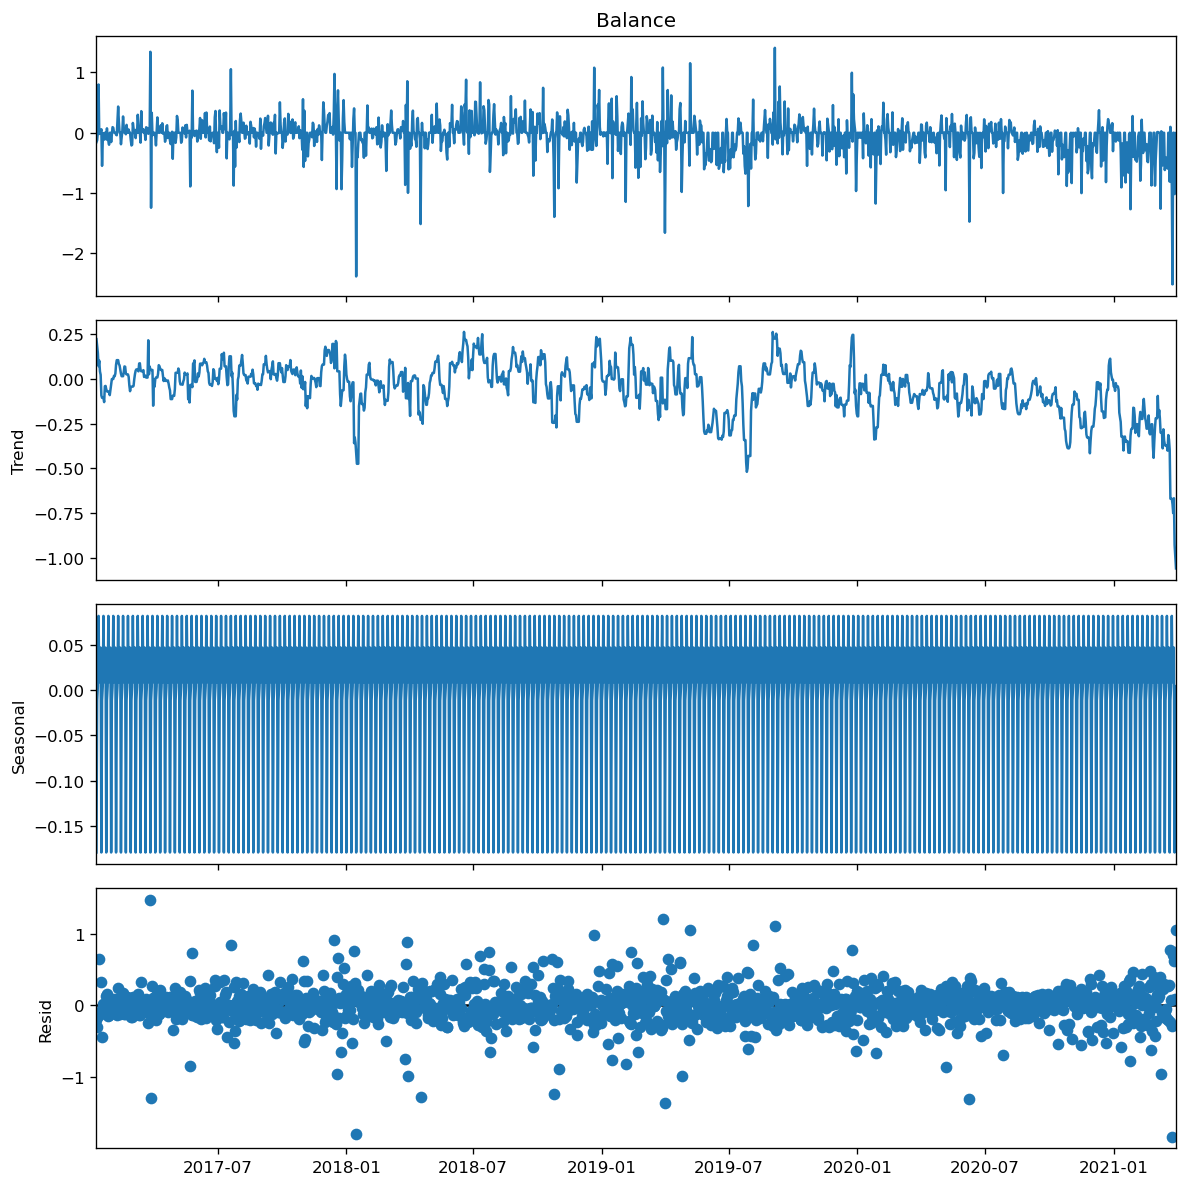

In [173]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

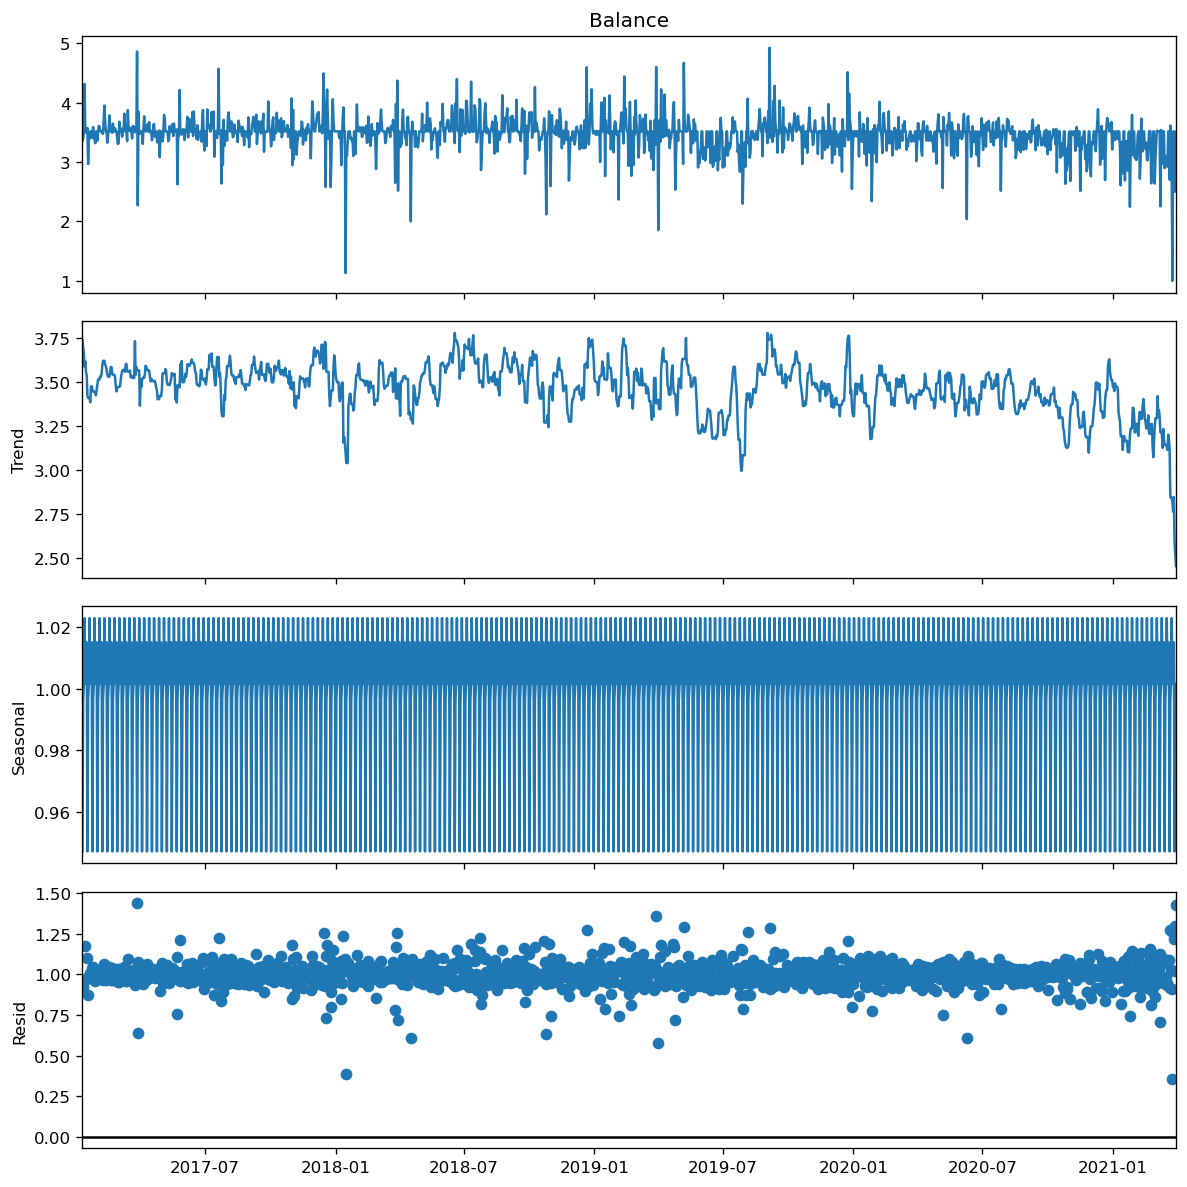

In [174]:
df.posBalance = df.Balance + np.abs(df.Balance.min()) + 1

result_mult = seasonal_decompose(df.posBalance, model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot()
plt.show()

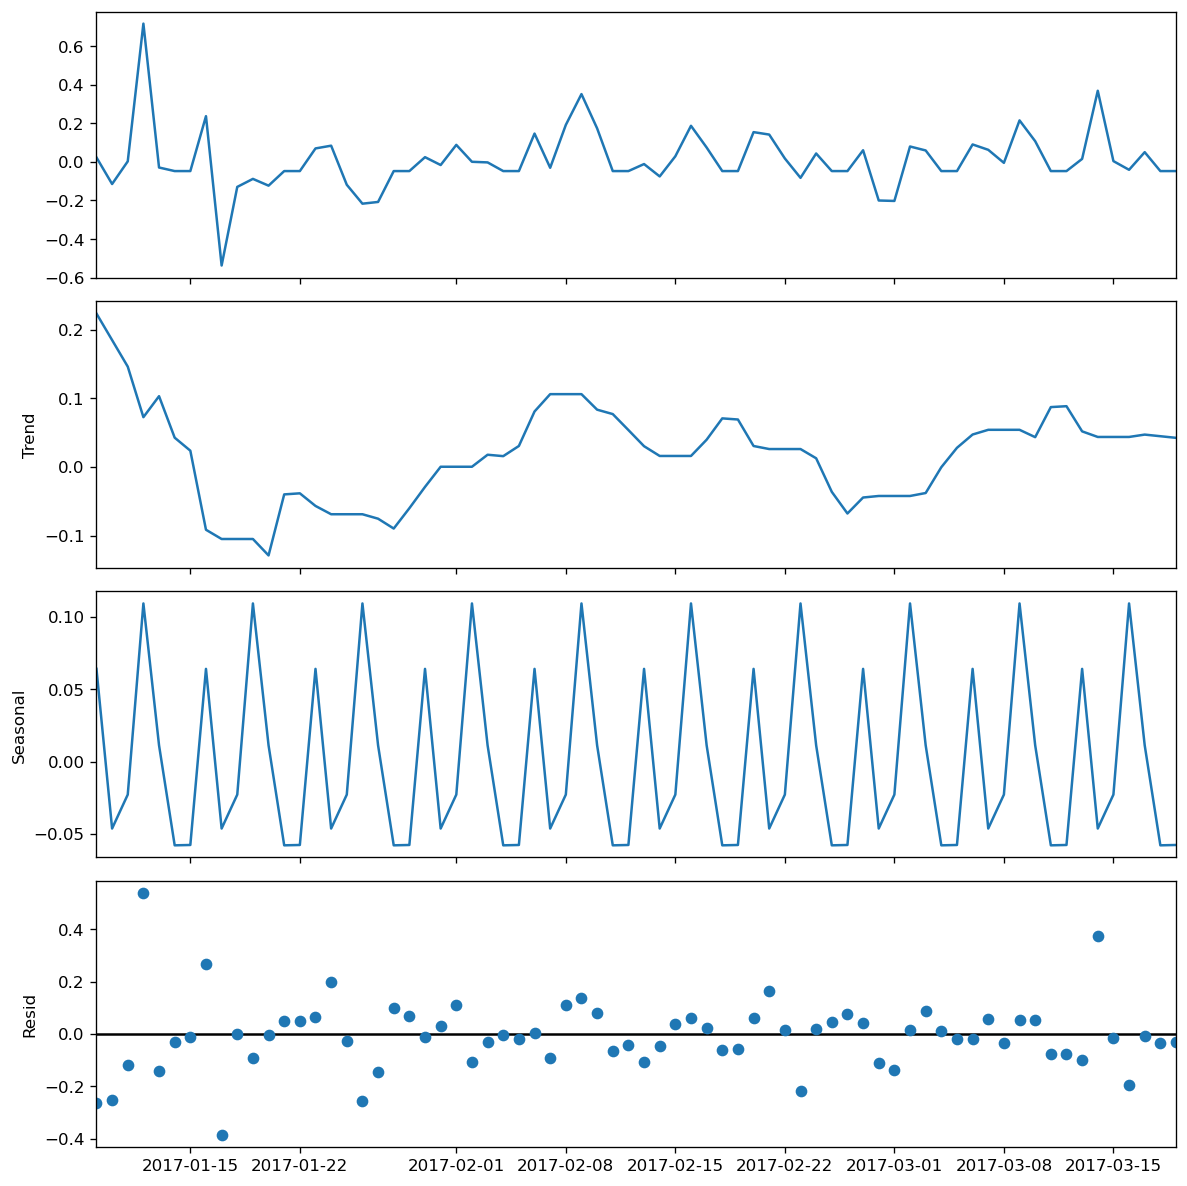

In [178]:
result = seasonal_decompose((df.Balance - result_add.seasonal)[:70], model='additive', extrapolate_trend='freq')
tmp = df.Balance - result_add.seasonal
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result.plot()
plt.show()

<Axes: xlabel='Date', ylabel='Balance'>

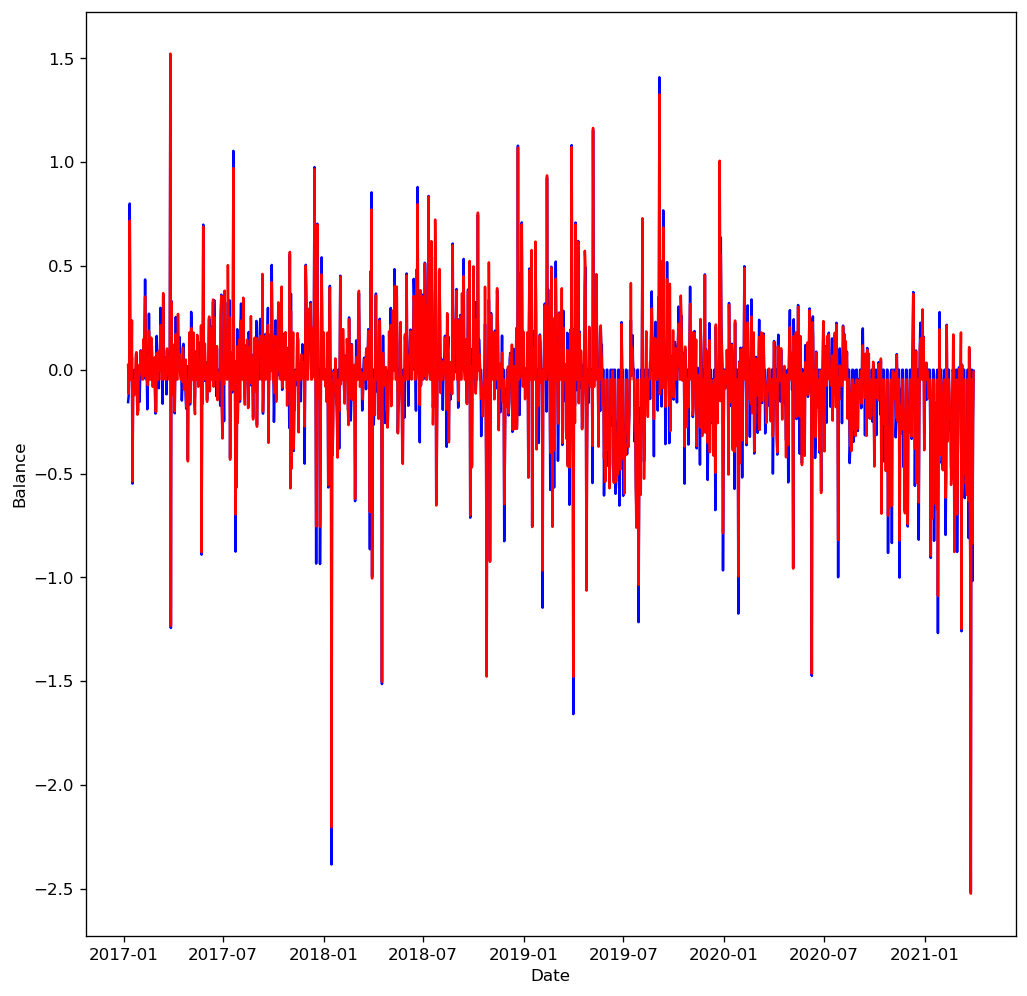

In [13]:
sns.lineplot(x=df.index, y=df.Balance, color = 'red')
sns.lineplot(x=df.index, y=df.Balance - result_add.seasonal, color = 'blue')

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

In [194]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise


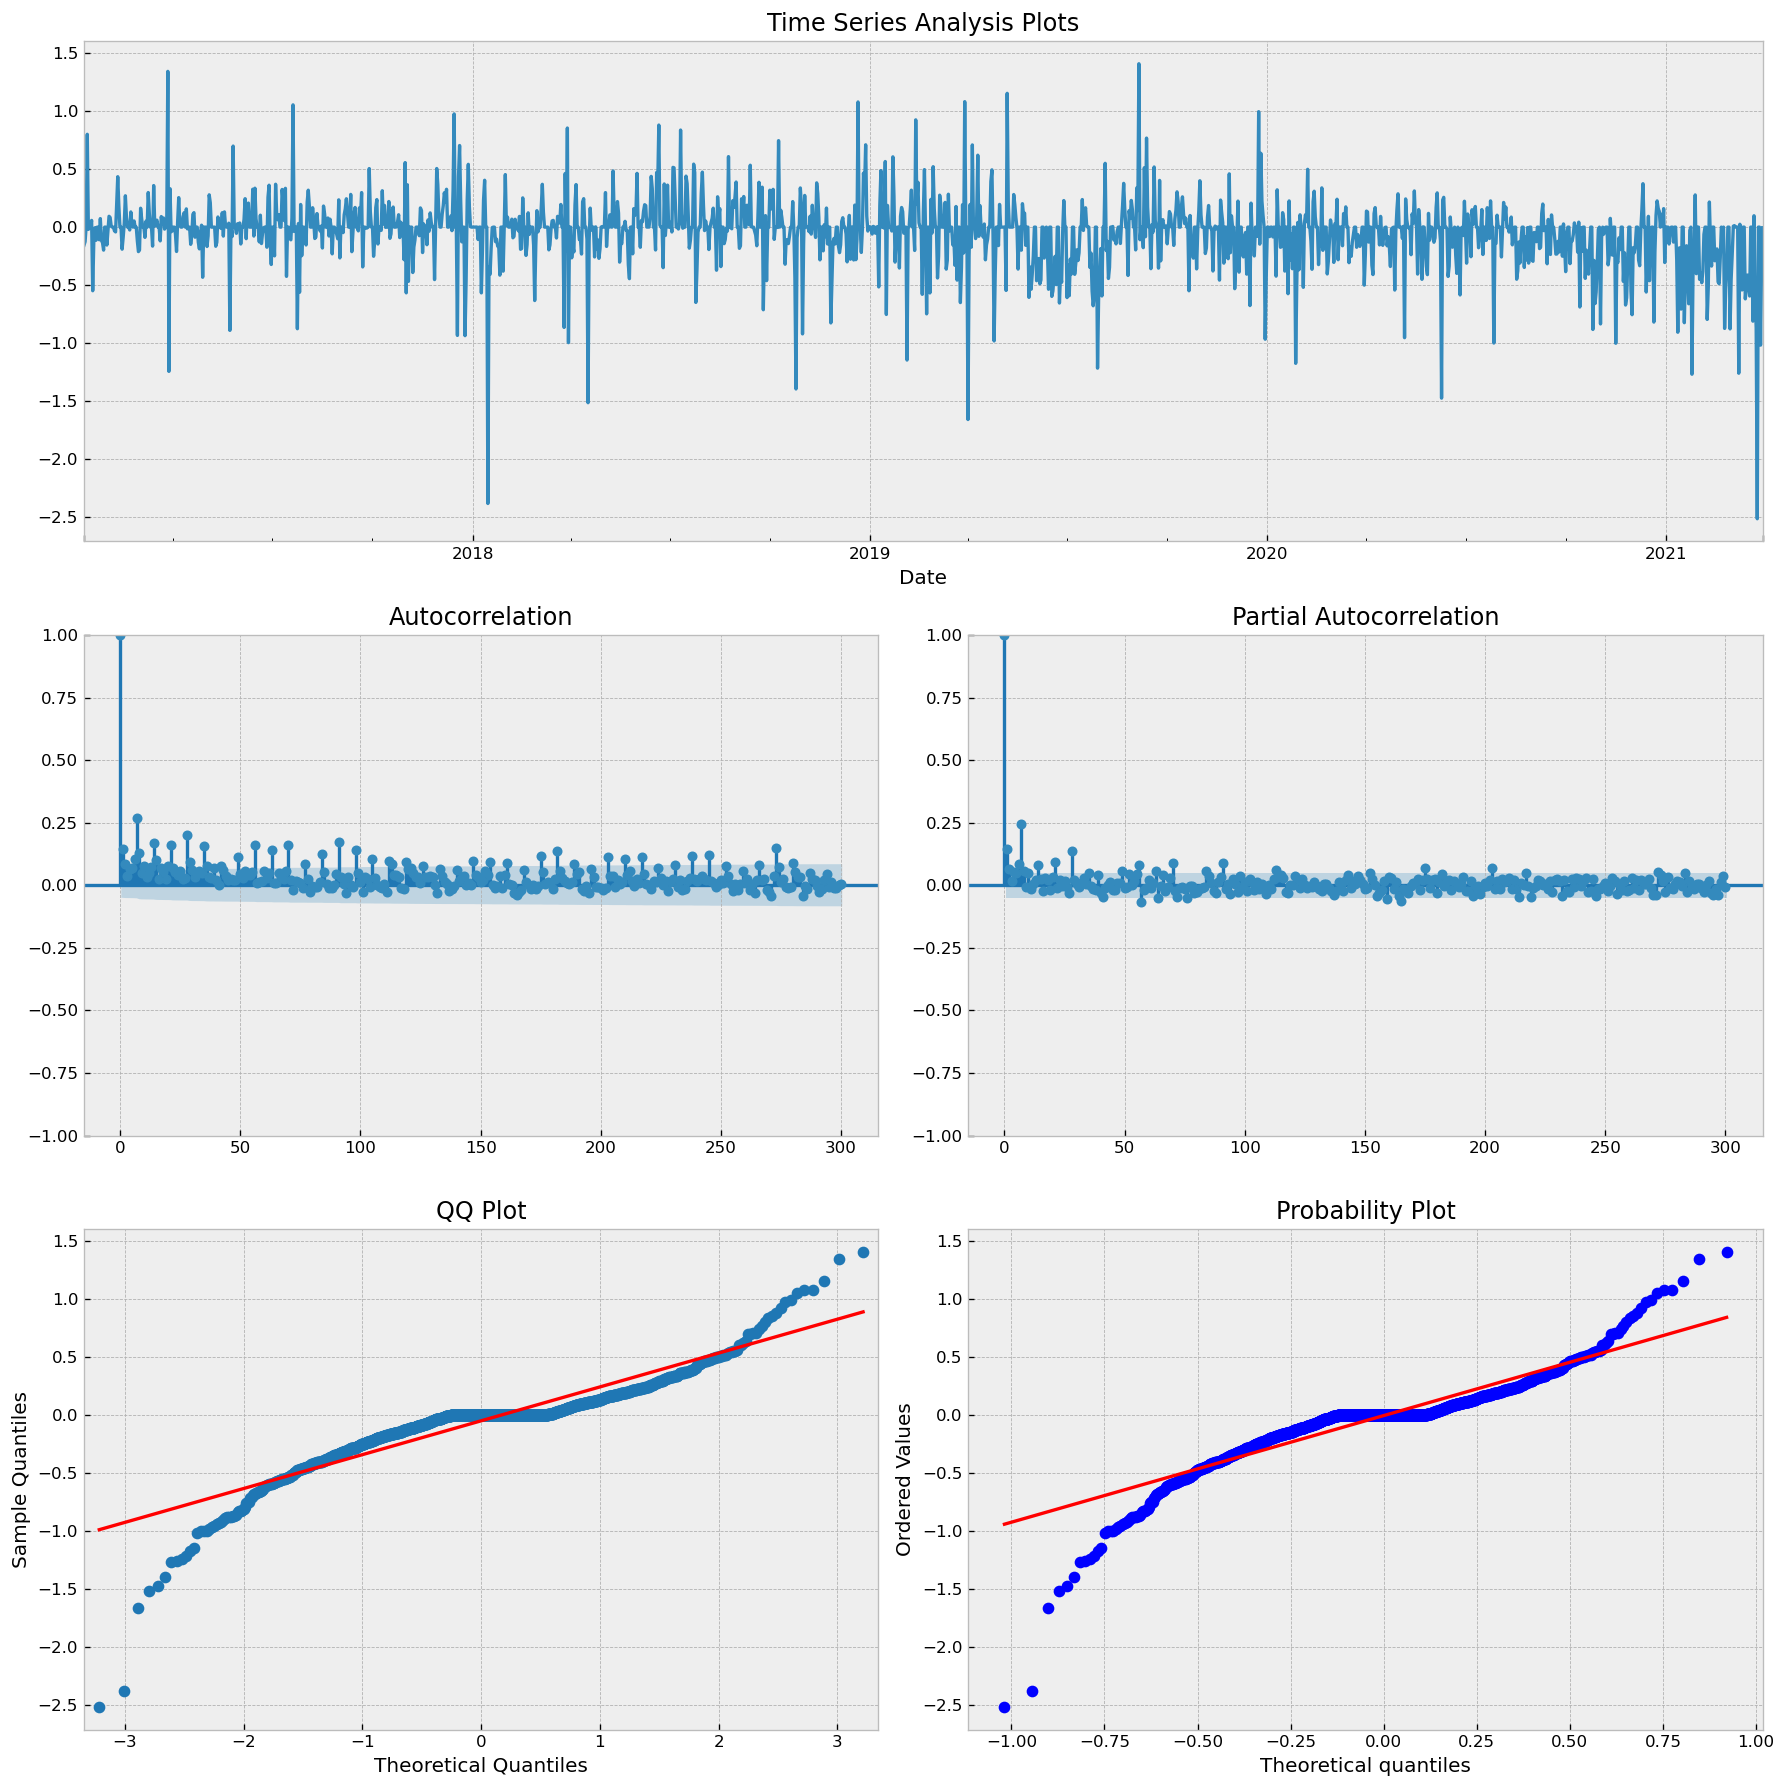

In [ ]:
tsplot(df.Balance, lags=30)

Похоже на SARIMA(p=2, i=0, q=2, P=5, I=0, Q=1, S=7)

In [593]:
try_model = ARIMA(endog=df.Balance[df.index < threshold_date], order=(2, 0, 2), seasonal_order=(5, 0, 1, 7)).fit()
try_model.llf

-118.8894065924165

Попробуем избавиться от сезонности дифференцированием

In [15]:
seasonality = 7

df.shift7 = (df.posBalance - df.posBalance.shift(7))[7:]
df.shift7x2 = df.shift7 - df.shift7.shift(7)

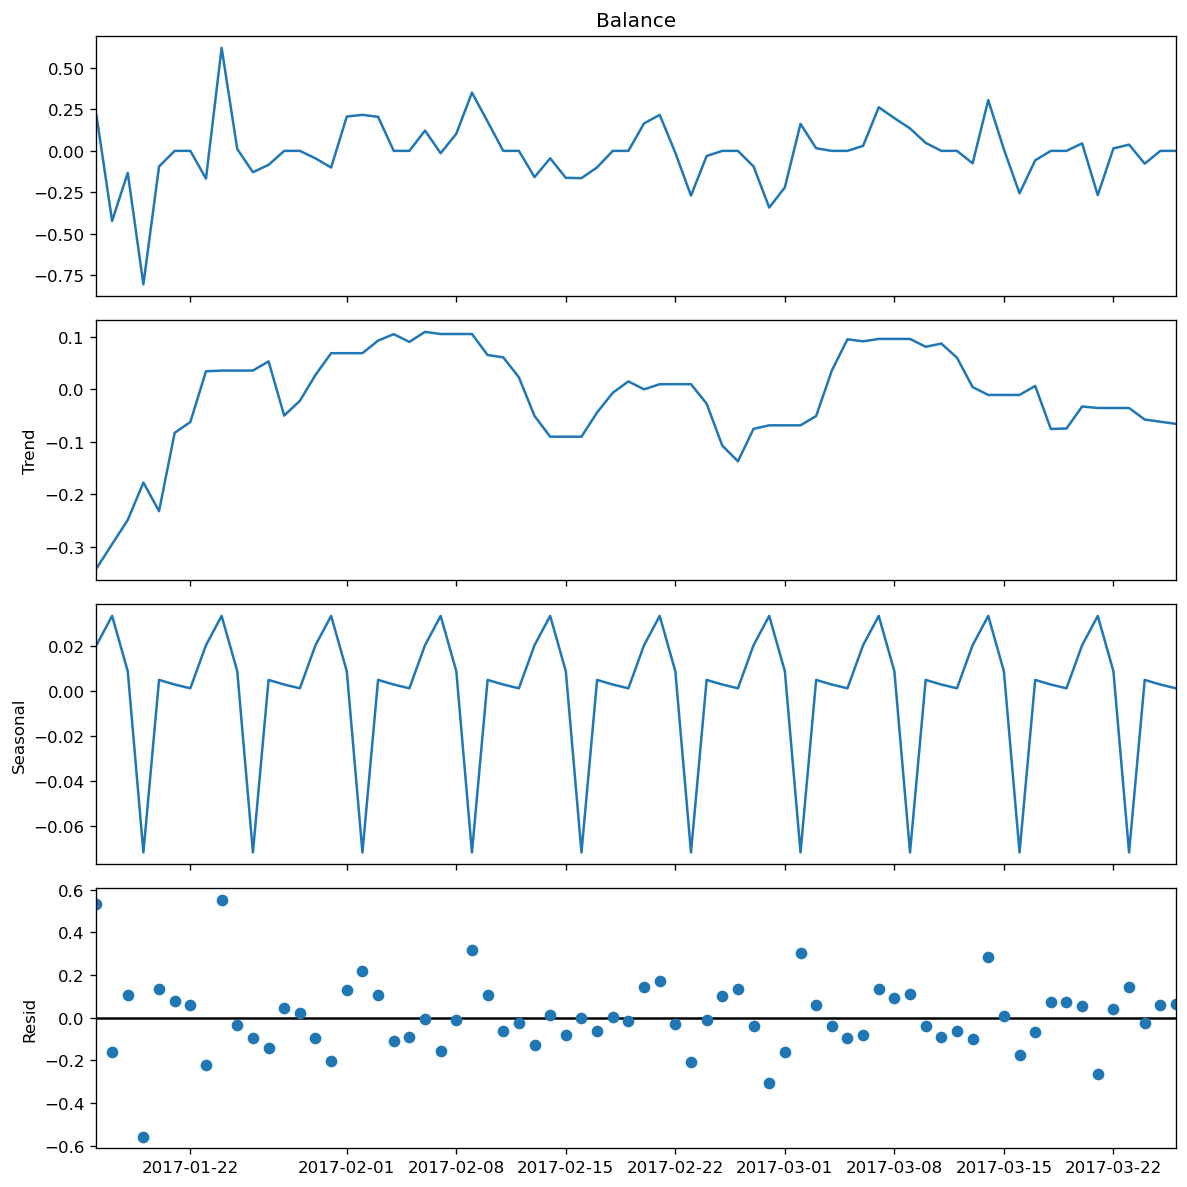

In [16]:
result_add = seasonal_decompose(df.shift7[:70], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

Вышло так себе

Здесь попытка сделать ряд положительным

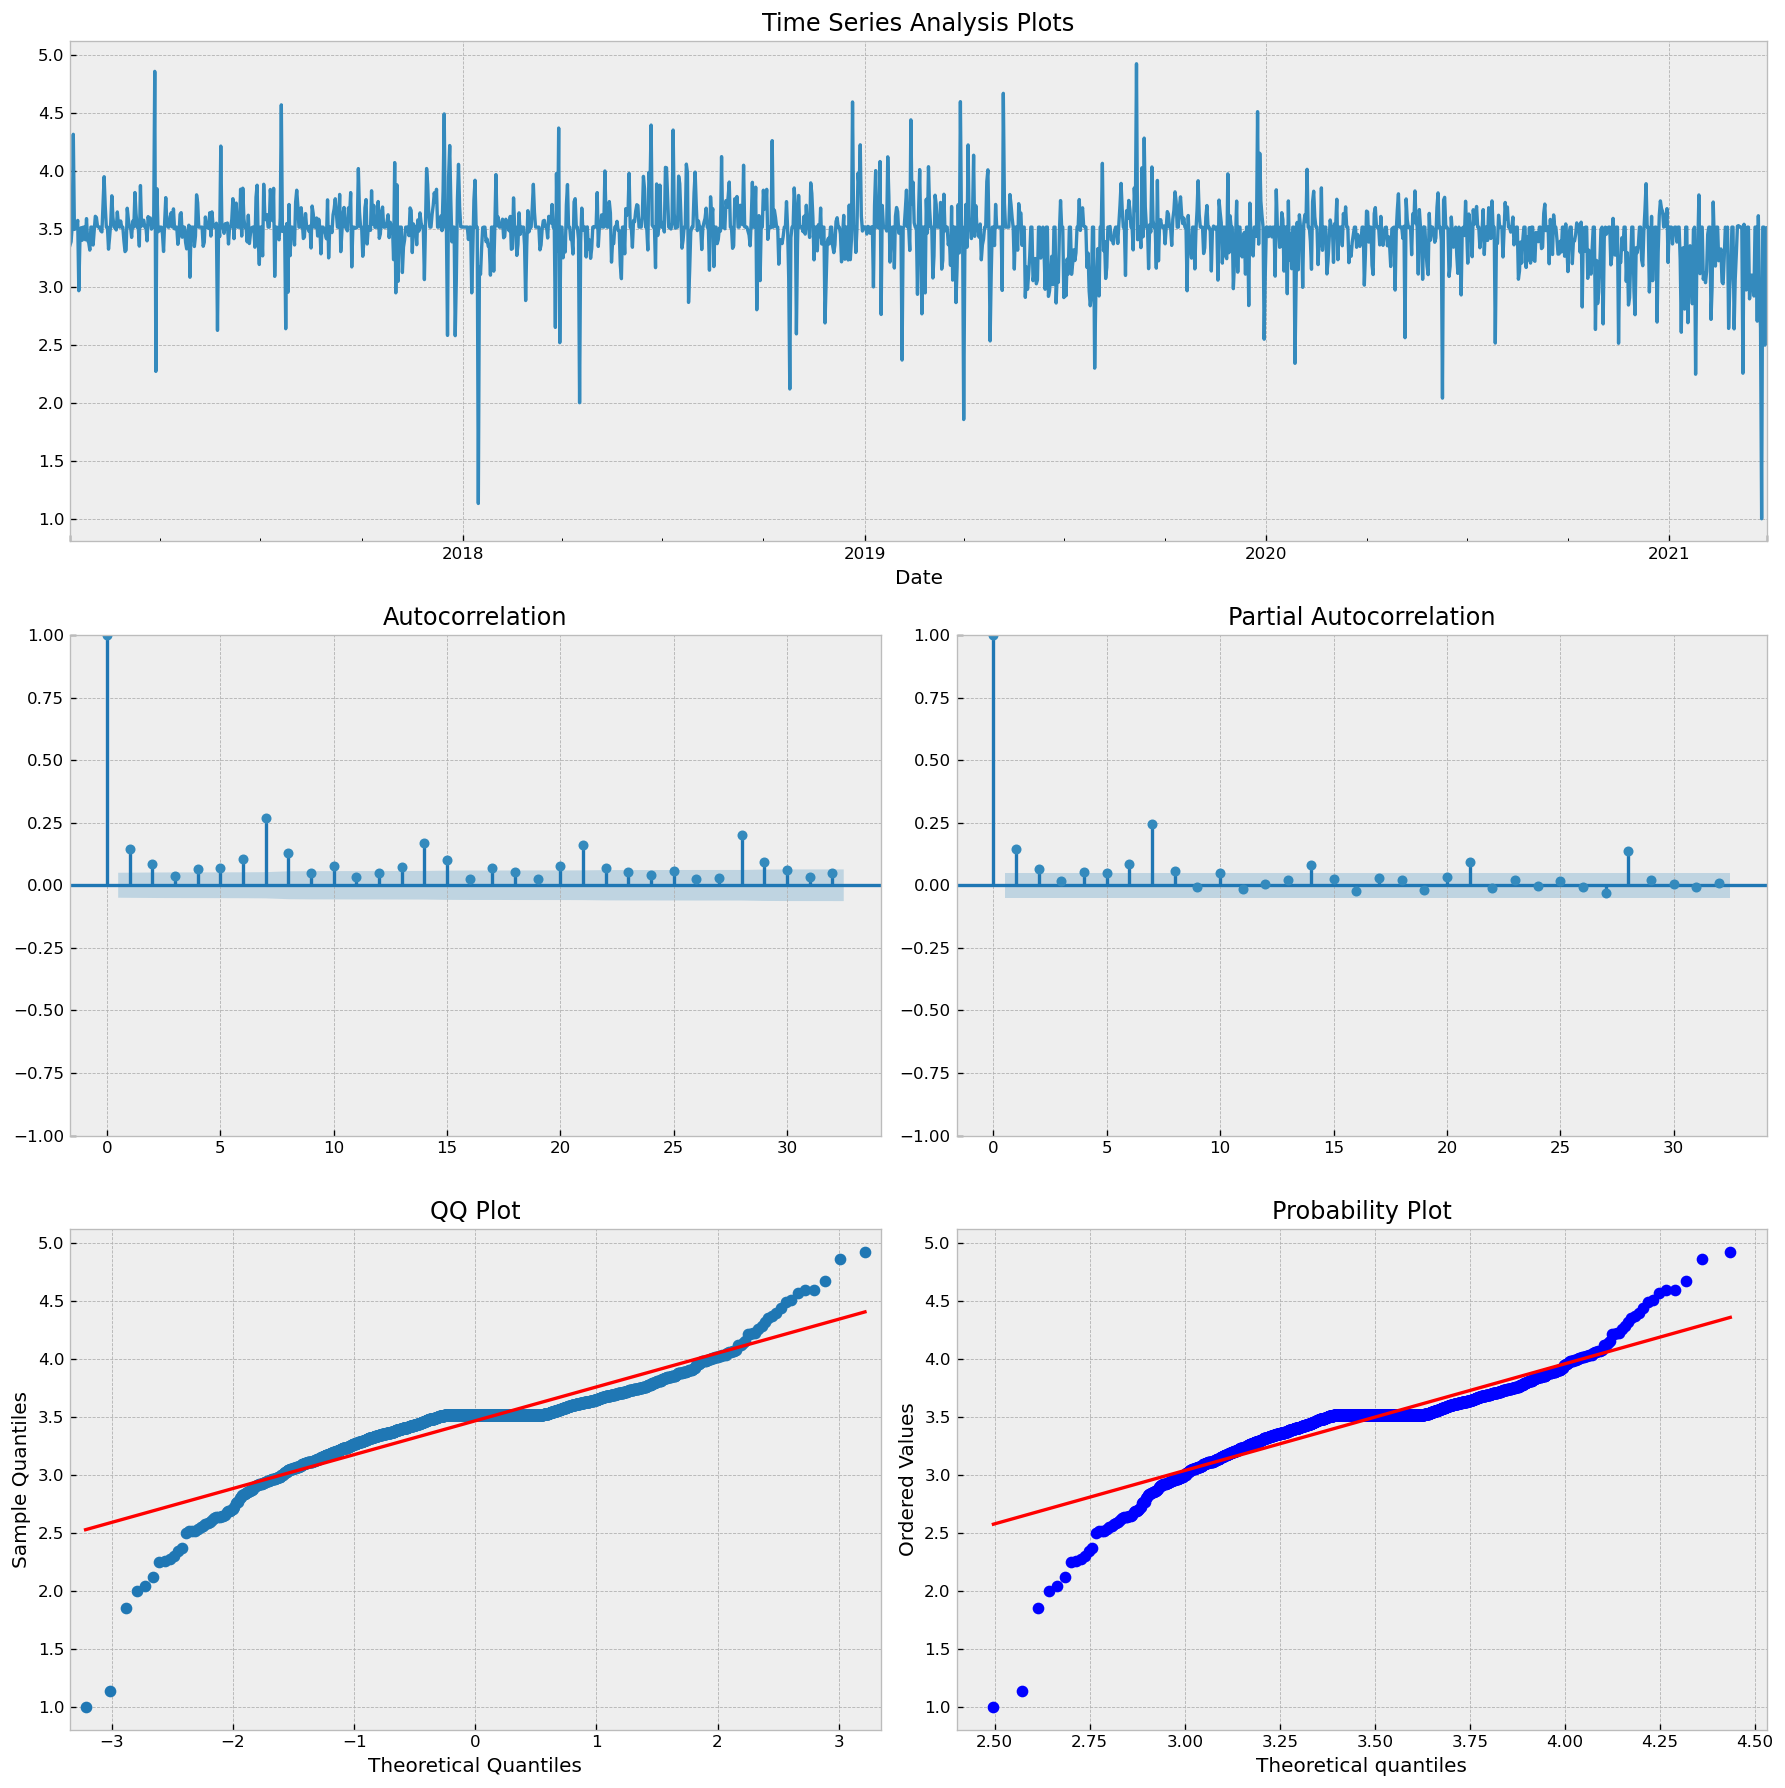

In [211]:
tsplot(df.posBalance)

# Моделирование

In [18]:
from sklearn.metrics import r2_score

In [19]:
start_date = np.datetime64('2017-06-30')
threshold_date = np.datetime64('2019-07-30')
end_date = np.datetime64('2021-01-10')

In [257]:
from tqdm import tqdm

In [592]:

ps = range(0, 3)
d = 0
qs = range(0, 3)
Ps = [1, 2, 5, 11]
Ds = range(1, 3)
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Ds, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for p, q, P, D, Q in tqdm(parameters_list):
    try:
        model_SARIMAX = ARIMA(endog=df.Balance[df.index < threshold_date], order=(p, d, q), seasonal_order=(P, D, Q, 7))
        model_SARIMAX = model_SARIMAX.fit()
    except ValueError:
        print('wrong parameters:', (p,d,q,P,D,Q))
        continue
    mask = (df.index >= threshold_date) & (df.index <= end_date)
    predict=model_SARIMAX.predict(start=threshold_date, end=end_date)
    err_max = (df.Balance[mask]-predict).abs().max()
    err_mean = (df.Balance[mask]-predict).abs().mean()
    llf = model_SARIMAX.llf
    r2 = r2_score(df.Balance[mask], predict)
    aic = model_SARIMAX.aic
    if aic < best_aic:
        best_chosen = model_SARIMAX
        best_err_max = err_max
        best_err_mean = err_mean
        best_llf = llf
        best_r2 = r2
        best_combination = (p,d,q,P,D,Q)
        best_aic = aic
    results.append([p, d, q, P, D, Q, err_max, err_mean, llf, r2, aic])

100%|██████████| 216/216 [54:44<00:00, 15.21s/it]  


In [261]:
best_combination

(1, 0, 1, 11, 1, 2)

In [262]:
result_exog_table = pd.DataFrame(results)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'err_mean', 'LLF', 'R2', 'aic']
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(10))
display(result_exog_table.sort_values(by='err_max', ascending=True).head(10))
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(10))

,p,d,q,P,D,Q,err_max,err_mean,LLF,R2,aic
212,2,0,2,11,1,2,1.388639,0.156004,-20.287247,0.128863,76.574493
116,1,0,1,11,1,2,1.399802,0.155688,-20.702344,0.124902,73.404688
188,2,0,1,11,1,2,1.379624,0.155316,-20.937945,0.128654,75.875891
140,1,0,2,11,1,2,1.381444,0.154951,-21.083807,0.128100,76.167614
68,0,0,2,11,1,2,1.377158,0.155120,-21.126794,0.129082,74.253587
164,2,0,0,11,1,2,1.370096,0.155828,-21.391016,0.125483,74.782032
92,1,0,0,11,1,2,1.406265,0.154081,-22.045134,0.122499,74.090269
44,0,0,1,11,1,2,1.415101,0.154066,-22.542423,0.120250,75.084846
20,0,0,0,11,1,2,1.415856,0.153132,-23.801609,0.118112,75.603217
211,2,0,2,11,1,1,1.387056,0.155619,-26.415938,0.133877,86.831877


,p,d,q,P,D,Q,err_max,err_mean,LLF,R2,aic
48,0,0,2,1,1,0,1.252852,0.179826,-107.355440,-0.106898,222.710881
144,2,0,0,1,1,0,1.253761,0.180067,-107.278910,-0.106149,222.557820
72,1,0,0,1,1,0,1.254231,0.178762,-108.039566,-0.112537,222.079132
24,0,0,1,1,1,0,1.254326,0.178761,-108.135559,-0.113252,222.271119
0,0,0,0,1,1,0,1.255022,0.177964,-109.061456,-0.117996,222.122911
96,1,0,1,1,1,0,1.260780,0.180245,-107.231143,-0.106871,222.462287
87,1,0,0,5,2,0,1.264263,0.192735,-147.411352,-0.313193,308.822704
63,0,0,2,5,2,0,1.264354,0.193322,-147.083375,-0.309138,310.166750
52,0,0,2,1,2,1,1.264535,0.189803,-127.111474,-0.233515,264.222948
39,0,0,1,5,2,0,1.264548,0.192724,-147.491949,-0.313679,308.983899


,p,d,q,P,D,Q,err_max,err_mean,LLF,R2,aic
116,1,0,1,11,1,2,1.399802,0.155688,-20.702344,0.124902,73.404688
92,1,0,0,11,1,2,1.406265,0.154081,-22.045134,0.122499,74.090269
68,0,0,2,11,1,2,1.377158,0.155120,-21.126794,0.129082,74.253587
164,2,0,0,11,1,2,1.370096,0.155828,-21.391016,0.125483,74.782032
44,0,0,1,11,1,2,1.415101,0.154066,-22.542423,0.120250,75.084846
20,0,0,0,11,1,2,1.415856,0.153132,-23.801609,0.118112,75.603217
188,2,0,1,11,1,2,1.379624,0.155316,-20.937945,0.128654,75.875891
140,1,0,2,11,1,2,1.381444,0.154951,-21.083807,0.128100,76.167614
212,2,0,2,11,1,2,1.388639,0.156004,-20.287247,0.128863,76.574493
115,1,0,1,11,1,1,1.386645,0.155461,-26.697192,0.133371,83.394384


In [263]:
best_chosen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Balance   No. Observations:                  611
Model:             ARIMA(1, 0, 1)x(11, 1, [1, 2], 7)   Log Likelihood                 -20.702
Date:                               Tue, 02 Apr 2024   AIC                             73.405
Time:                                       21:56:18   BIC                            143.862
Sample:                                   07-30-2019   HQIC                           100.824
                                        - 03-31-2021                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8727      0.128      6.807      0.000       0.621       1.124
ma.L1         -0.8209      0.148     -5.564      0.000      -1.110      -0.532
ar.S.L7       -0.6229      0.074     -8.402      0.000      -0.768      -0.478
ar.S.L14      -1.4738      0.097    -15.181      0.000      -1.664      -1.284
ar.S.L21      -1.2903      0.118    -10.959      0.000      -1.521      -1.060
ar.S.L28      -1.0756      0.136     -7.898      0.000      -1.343      -0.809
ar.S.L35      -1.0151      0.139     -7.311      0.000      -1.287      -0.743
ar.S.L42      -0.9068      0.129     -7.055      0.000      -1.159      -0.655
ar.S.L49      -0.7130      0.126     -5.637      0.000      -0.961      -0.465
ar.S.L56      -0.6137      0.114     -5.404      0.000      -0.836      -0.391
ar.S.L63      -0.4466      0.096     -4.676      0.000      -0.634      -0.259
ar.S.L70      -0.1277      0.066     -1.940      0.052      -0.257       0.001
ar.S.L77      -0.1833      0.056     -3.297      0.001      -0.292      -0.074
ma.S.L7       -0.1782      0.059     -3.001      0.003      -0.295      -0.062
ma.S.L14       0.9427      0.066     14.380      0.000       0.814       1.071
sigma2         0.0619      0.002     25.203      0.000       0.057       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              2029.60
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.92
Prob(H) (two-sided):                  0.23   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [594]:
import pmdarima as pm
best_auto = pm.AutoARIMA(
                        # test='adf',
                        # start_p=0, end_p=5,
                        # start_q=0, end_q=5,
                        start_P=0, end_P=12,
                        start_D=0, end_D=3,
                        # start_Q=0, end_Q=5,
                        m=7,
                        seasonal=True,
                        stationary=True,
                        trace=True,
                        suppress_warnings=True,
                        error_action='ignore',
                        stepwise=True
                      ).fit(y=df.Balance[df.index < threshold_date])

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=280.868, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=318.994, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=276.773, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=280.467, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=318.449, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=312.182, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=277.277, Time=0.45 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=264.730, Time=0.58 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=280.043, Time=0.25 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=279.704, Time=0.36 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=257.776, Time=1.76 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=260.984, Time=1.60 sec
 ARIMA(2,0,0)(2,0,2)[7] intercept   : AIC=259.877, Time=2.06 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept

In [595]:
best_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  932
Model:             SARIMAX(3, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood                -120.041
Date:                                Wed, 03 Apr 2024   AIC                            256.081
Time:                                        01:13:15   BIC                            294.780
Sample:                                    01-09-2017   HQIC                           270.840
                                         - 07-29-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.001     -0.838      0.402      -0.002       0.001
ar.L1          0.0697      0.027      2.538      0.011       0.016       0.124
ar.L2          0.0325      0.036      0.896      0.370      -0.039       0.104
ar.L3         -0.0471      0.029     -1.648      0.099      -0.103       0.009
ar.S.L7        0.9654      0.025     38.222      0.000       0.916       1.015
ma.S.L7       -0.8006      0.040    -20.133      0.000      -0.878      -0.723
ma.S.L14      -0.1087      0.033     -3.290      0.001      -0.173      -0.044
sigma2         0.0754      0.002     44.787      0.000       0.072       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4147.37
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Максимальная и средняя ошибки для выбранной авто:

In [596]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_auto=best_auto.predict_in_sample(start=threshold_date, end=end_date)
err_auto = (df.Balance[mask]-predict_auto).abs()
print(err_auto.max(), err_auto.mean())

1.4943486963982928 0.15698160122932367


Максимальная и средняя ошибки для выбранной перебором:

In [597]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_chosen = best_chosen.predict(start=threshold_date, end=end_date)
err_chosen = (df.Balance[mask]-predict_chosen).abs()
print(err_chosen.max(), err_chosen.mean())

1.4824307989058232 0.14519466228701403


<Axes: xlabel='Date', ylabel='predicted_mean'>

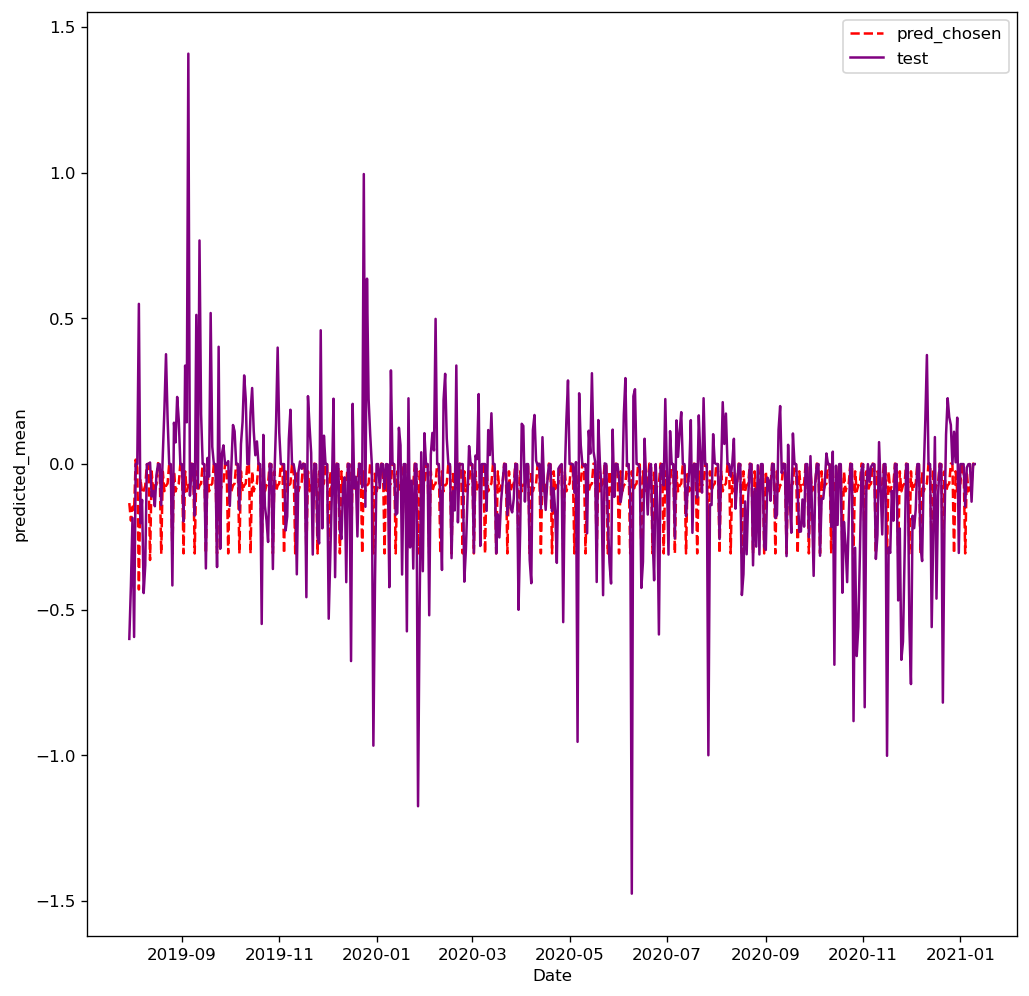

In [598]:
# sns.lineplot(y=df.posBalance[df.index < threshold_date], x=df.index[df.index < threshold_date], label='train')
sns.lineplot(x=df.index[mask], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

<Axes: xlabel='Date', ylabel='predicted_mean'>

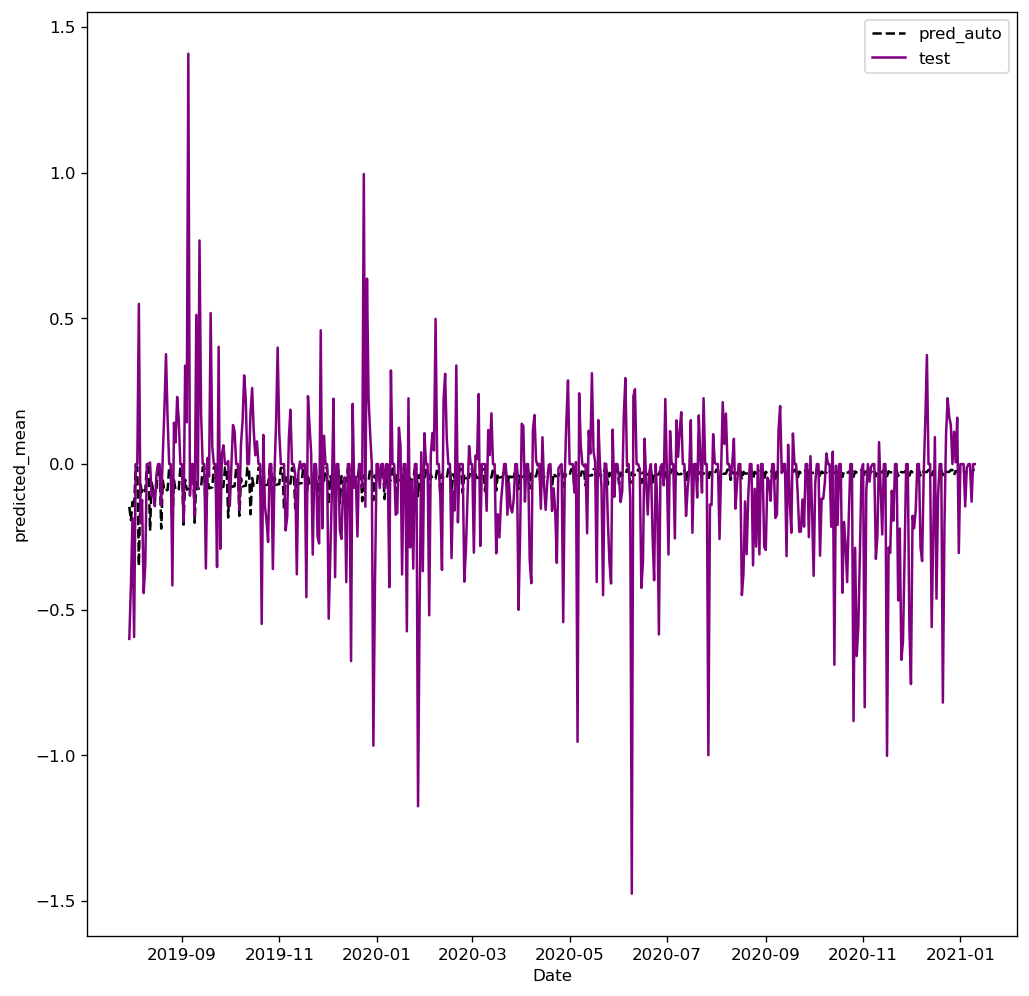

In [599]:
sns.lineplot(x=df.index[mask], y=predict_auto, label='pred_auto', linestyle='dashed', color='black')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

<Axes: xlabel='Date'>

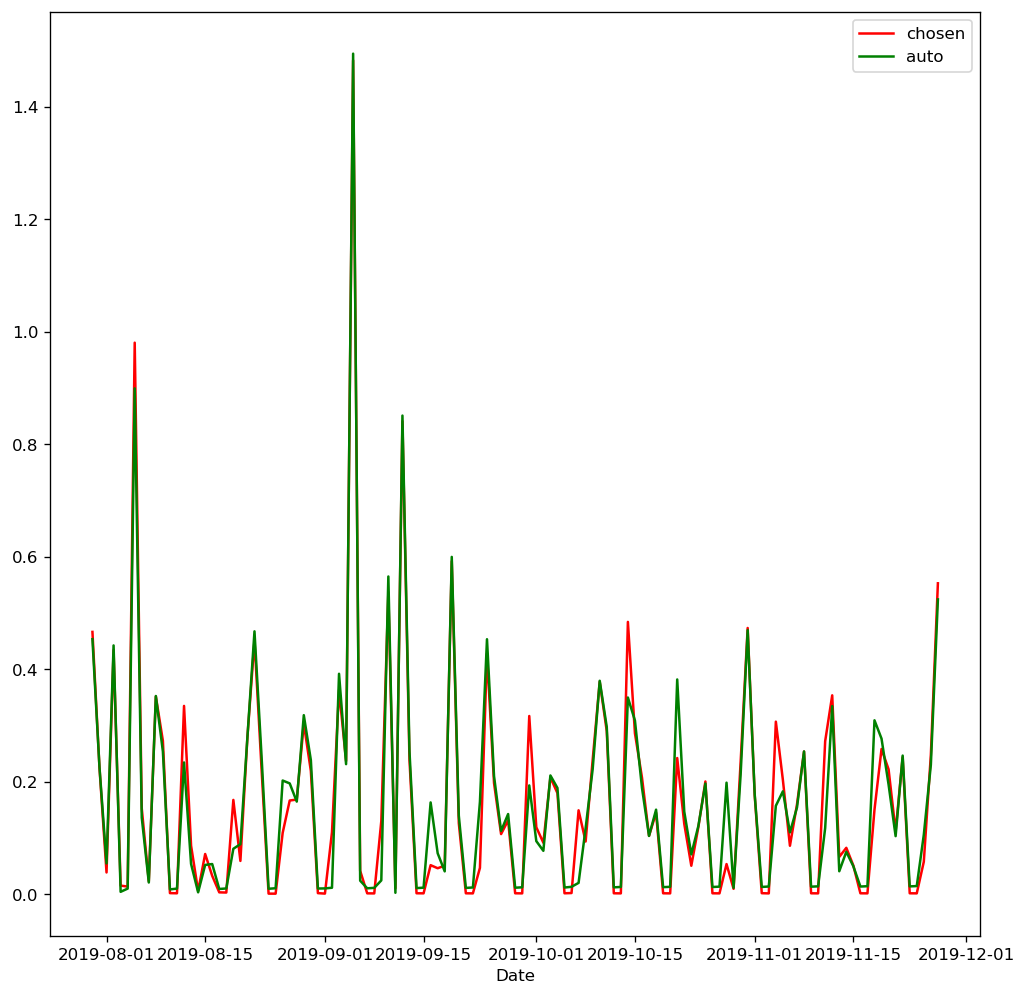

In [600]:
sns.lineplot(x=df.index[mask][:121], y=(df.Balance[mask]-predict_chosen)[:121].abs(), label='chosen', color = 'red')
sns.lineplot(x=df.index[mask][:121], y=(df.Balance[mask]-predict_auto)[:121].abs(), label='auto', color = 'green')

# sns.lineplot(x=df.index[mask][21:], y=df.Balance[mask][21:], label='test', color = 'purple')

Попробуем выбрать из тех, что с минимальной LLF

In [601]:
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(1))

,p,d,q,P,D,Q,err_max,err_mean,LLF,R2,aic
212,2,0,2,11,1,2,1.388639,0.156004,-20.287247,0.128863,76.574493


In [602]:
# 	1	0	1	4	0	4	0.649590	-26.883264	0.299776	77.766529
#   1	0	1	11	0	2	1.404659	0.151452	-24.272138	0.174824	82.544276
model_by_llf = ARIMA(endog=df.Balance[df.index >= threshold_date], order=(2, 0, 2), seasonal_order=(11, 1, 2, 7)).fit()

In [603]:
model_by_llf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          Balance   No. Observations:                  611
Model:             ARIMA(2, 0, 2)x(11, 1, 2, 7)   Log Likelihood                 -20.287
Date:                          Wed, 03 Apr 2024   AIC                             76.574
Time:                                  01:14:03   BIC                            155.839
Sample:                              07-30-2019   HQIC                           107.421
                                   - 03-31-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.337     -0.099      0.921      -0.695       0.628
ar.L2          0.7856      0.309      2.543      0.011       0.180       1.391
ma.L1          0.0806      0.358      0.225      0.822      -0.621       0.782
ma.L2         -0.7200      0.313     -2.299      0.022      -1.334      -0.106
ar.S.L7       -0.6050      0.073     -8.309      0.000      -0.748      -0.462
ar.S.L14      -1.4599      0.095    -15.391      0.000      -1.646      -1.274
ar.S.L21      -1.2560      0.115    -10.938      0.000      -1.481      -1.031
ar.S.L28      -1.0324      0.134     -7.696      0.000      -1.295      -0.770
ar.S.L35      -0.9829      0.135     -7.262      0.000      -1.248      -0.718
ar.S.L42      -0.8718      0.126     -6.891      0.000      -1.120      -0.624
ar.S.L49      -0.6790      0.126     -5.398      0.000      -0.926      -0.432
ar.S.L56      -0.5968      0.113     -5.280      0.000      -0.818      -0.375
ar.S.L63      -0.4350      0.096     -4.509      0.000      -0.624      -0.246
ar.S.L70      -0.1181      0.066     -1.800      0.072      -0.247       0.011
ar.S.L77      -0.1868      0.056     -3.356      0.001      -0.296      -0.078
ma.S.L7       -0.1747      0.058     -3.029      0.002      -0.288      -0.062
ma.S.L14       0.9447      0.064     14.684      0.000       0.819       1.071
sigma2         0.0608      0.002     25.214      0.000       0.056       0.066
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              2032.16
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.93
Prob(H) (two-sided):                  0.21   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [604]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_by_llf = model_by_llf.predict(start=threshold_date, end=end_date)

<Axes: xlabel='Date', ylabel='predicted_mean'>

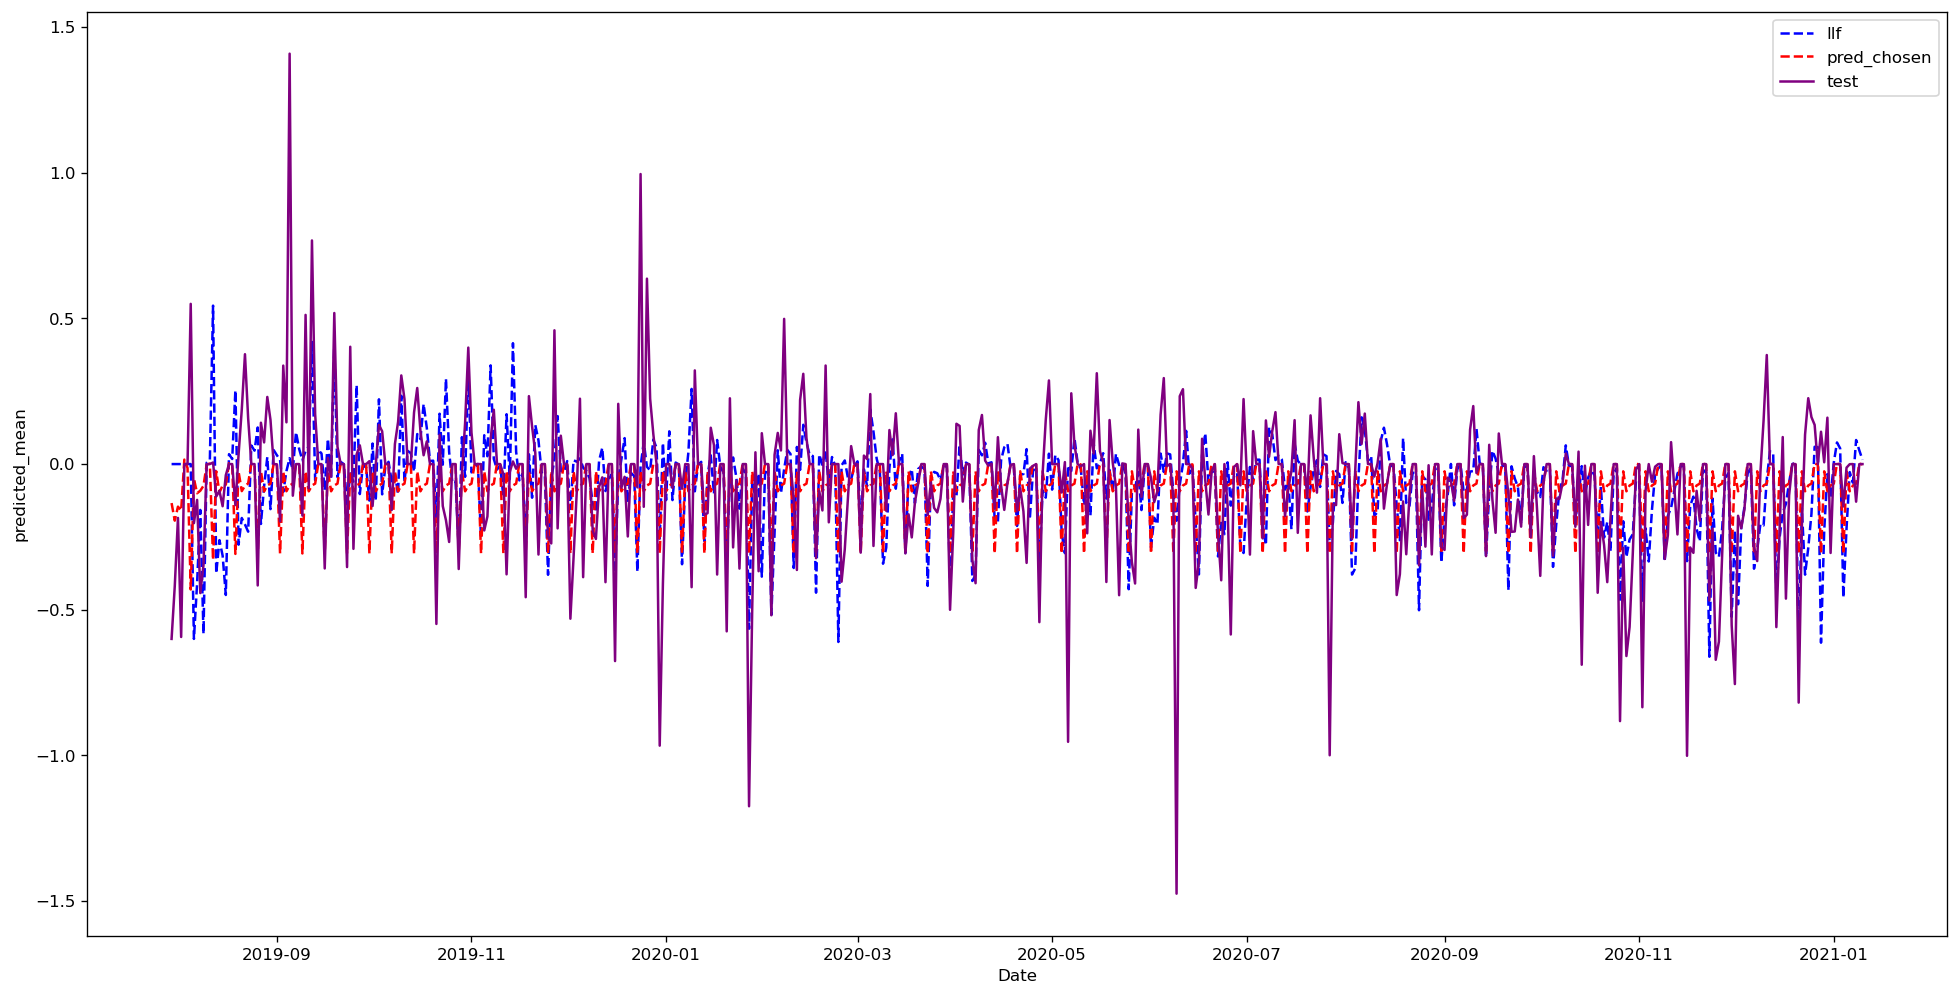

In [605]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=df.index[mask], y=predict_by_llf, label='llf', linestyle='dashed', color='blue', ax = ax)
# sns.lineplot(x=df.index[mask], y=predict_auto, label='pred_auto', linestyle='dashed', color='black', ax=ax)
sns.lineplot(x=df.index[mask], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red', ax=ax)

sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

<Axes: xlabel='Date'>

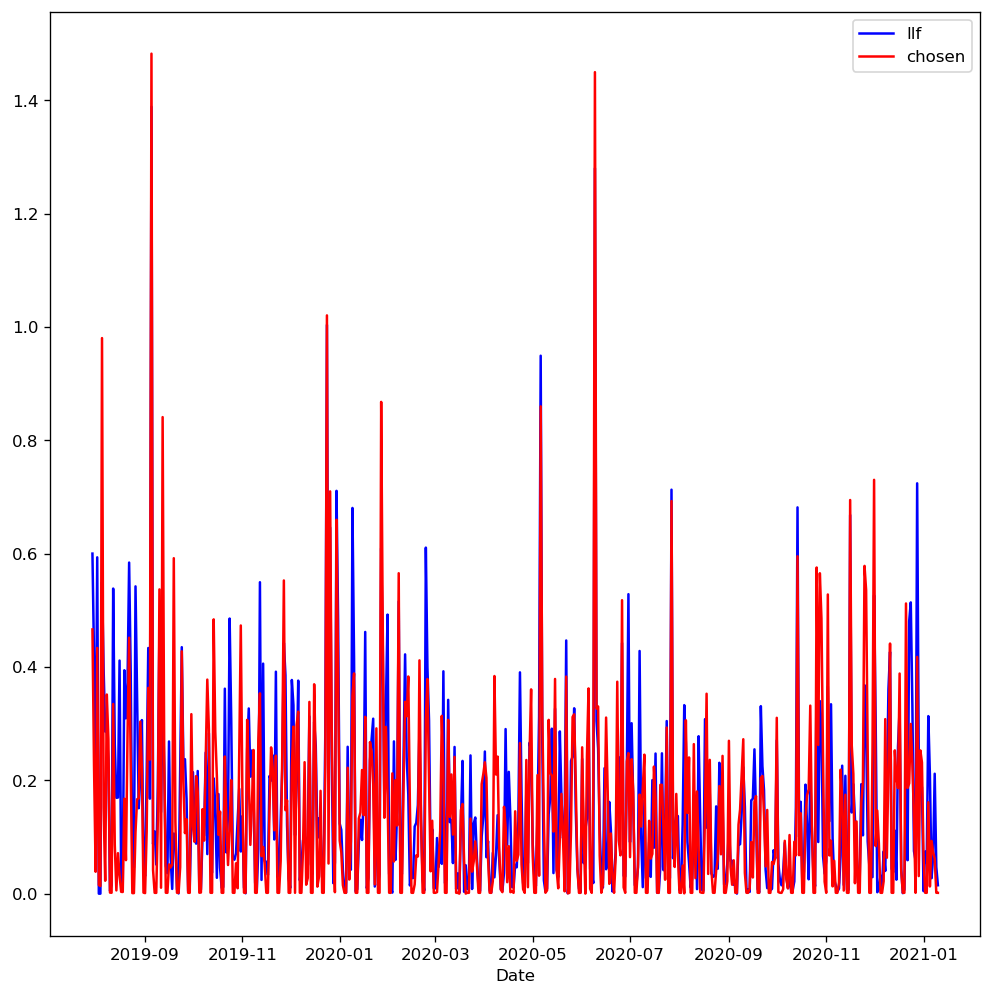

In [606]:
sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict_by_llf).abs(), label='llf', color = 'blue')
sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict_chosen).abs(), label='chosen', color = 'red')
# sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict_auto).abs(), label='auto', color = 'green')


In [607]:
print(f"mean chosen = {(df.Balance[mask]-predict_chosen).abs().mean()}")
print(f"mean by_llf = {(df.Balance[mask]-predict_by_llf).abs().mean()}")
print(f"max chosen = {(df.Balance[mask]-predict_chosen).abs().max()}")
print(f"max by_llf = {(df.Balance[mask]-predict_by_llf).abs().max()}")

mean chosen = 0.14519466228701403
mean by_llf = 0.1560037226713292
max chosen = 1.4824307989058232
max by_llf = 1.3886394520846637


### Предположим мы взяли chosen модель

**Посмотрим как ведут себя остатки**

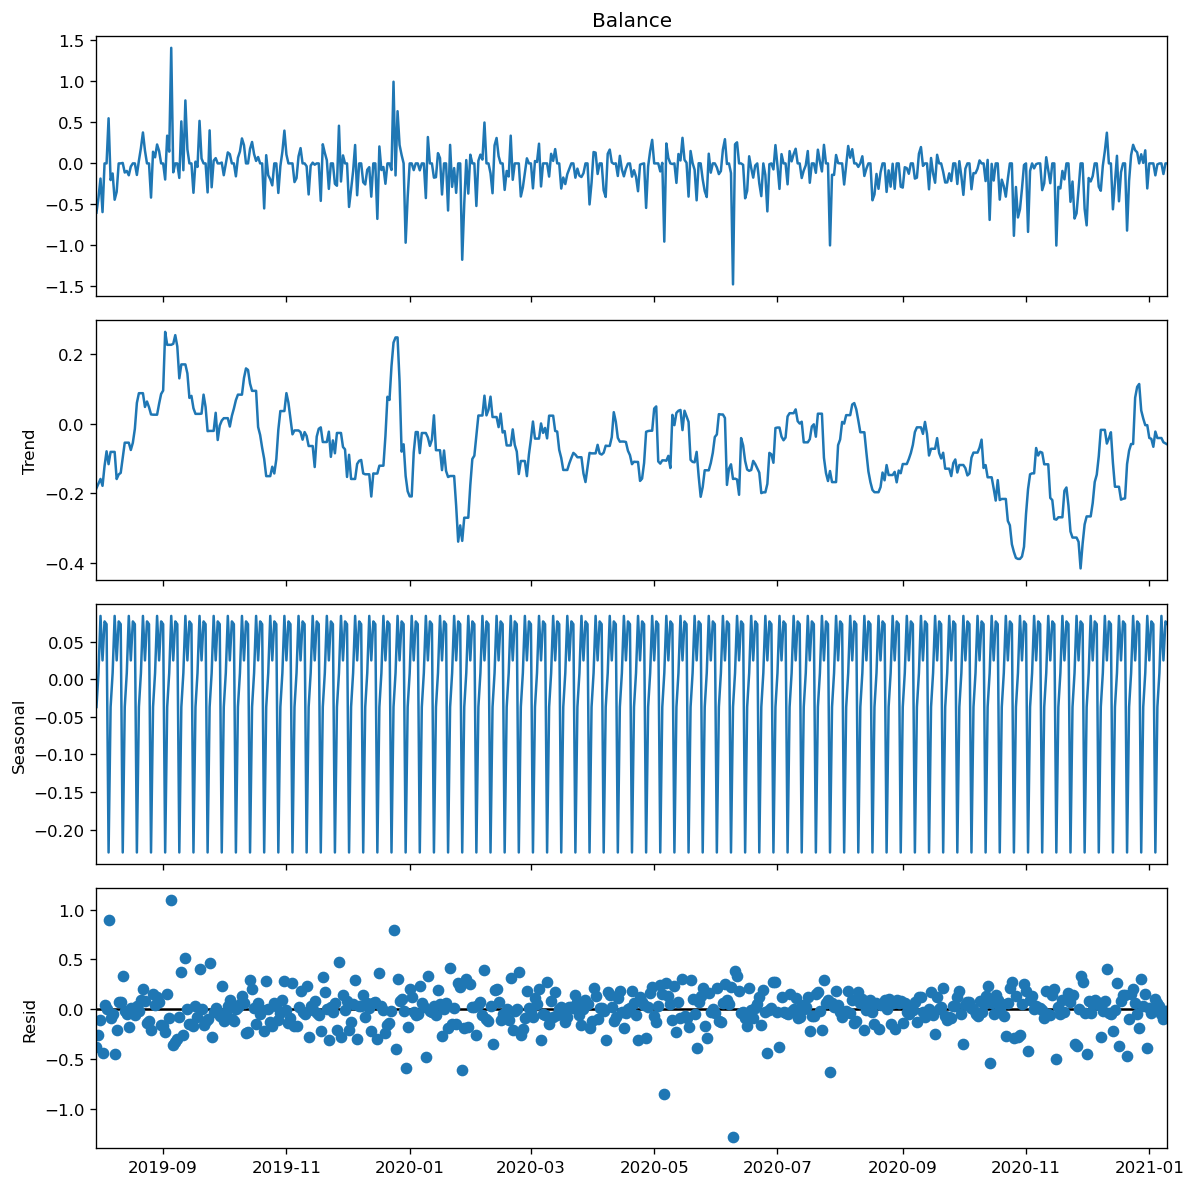

In [608]:
result_add = seasonal_decompose(df.Balance[mask], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

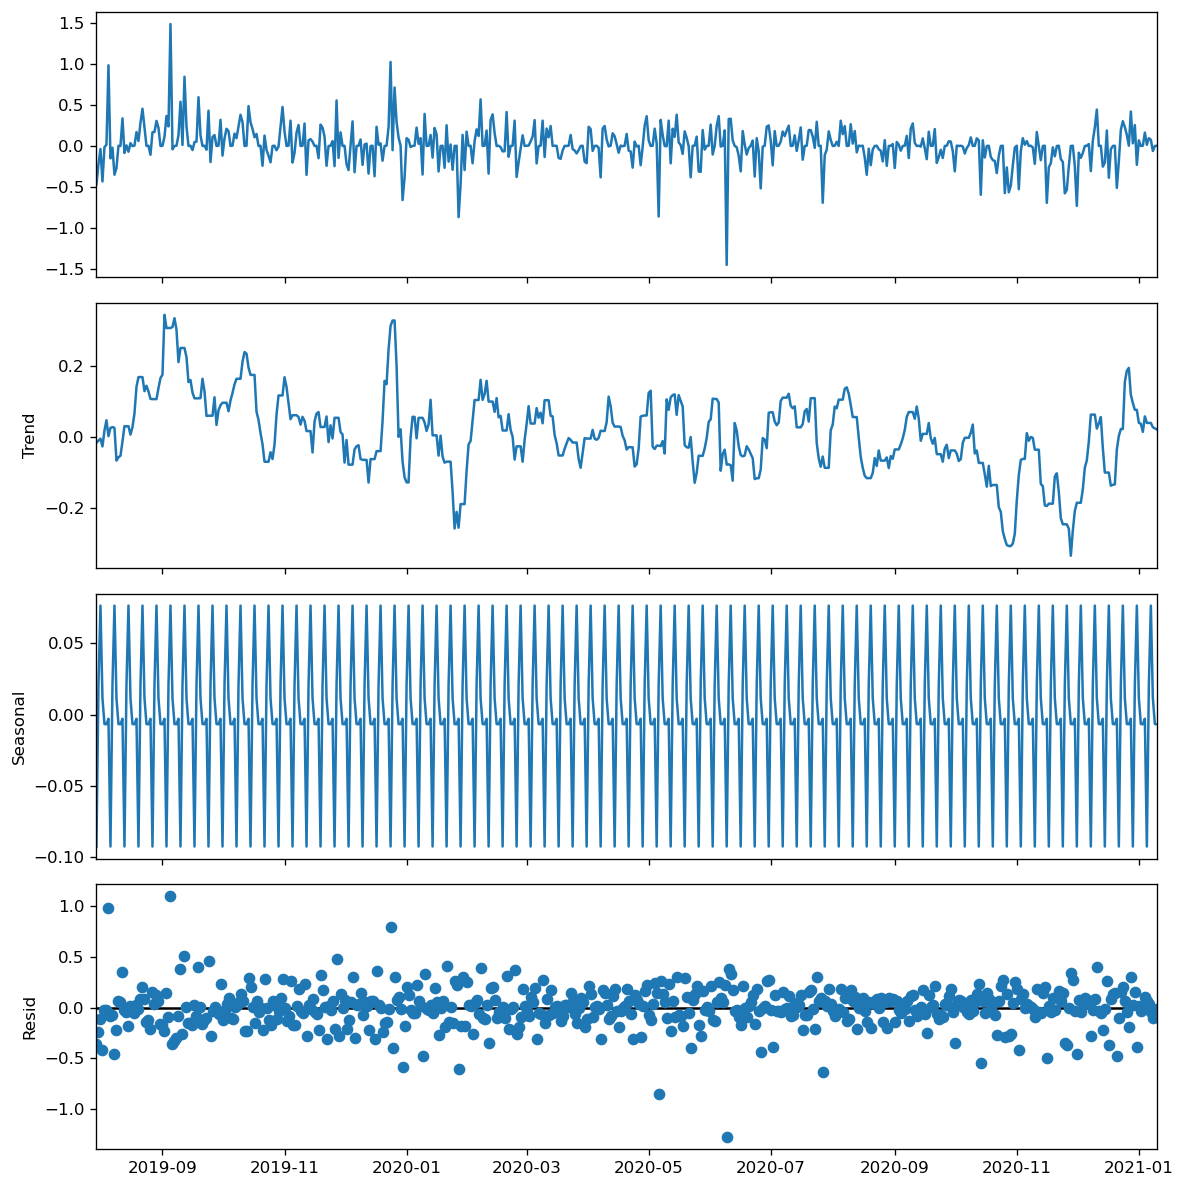

In [609]:
result_add = seasonal_decompose(df.Balance[mask] - predict_chosen, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Попробуем зафигачить фичи дополнительные

# Курс доллара

In [610]:
print(df.index[0], df.index[-1])

2017-01-09 00:00:00 2021-03-31 00:00:00


In [611]:
USD_RUB_df = pd.read_csv(
    "/home/owner/Documents/DEV/Time_series/USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )

In [612]:
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

In [613]:
new_df = df.join(USD_RUB_df)
new_df

,Income,Outcome,Balance,summer,USD
Date,,,,,
2017-01-09,1.343028,1.487865,-0.155904,2017-01-09,"57,5159"
2017-01-10,1.068610,1.194182,-0.125572,2017-01-10,NaN
2017-01-11,0.944429,0.936663,0.007767,2017-01-11,"58,2807"
2017-01-12,1.672202,0.875379,0.800391,2017-01-12,"58,8960"
2017-01-13,0.955924,0.975645,-0.019721,2017-01-13,"59,6869"
...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,2021-03-27,NaN
2021-03-28,0.000000,0.000000,0.000000,2021-03-28,NaN
2021-03-29,2.356883,3.370738,-1.017679,2021-03-29,"75,6648"


In [614]:
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)

In [615]:
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)

# ВВП РФ

In [616]:
GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (pd.to_datetime(new_df.index).year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

# Ключевая ставка

In [617]:
keyRates = pd.read_csv('/home/owner/Documents/DEV/Time_series/KeyRate.csv')

# Праздничные дни

In [618]:
import holidays

In [619]:
all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
all_holidays

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-08', '2017-01-07',
               '2017-02-23', '2017-03-08', '2017-05-01', '2017-05-09',
               '2017-06-12', '2017-11-04', '2018-01-01', '2018-01-02',
               '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-08', '2018-01-07', '2018-02-23', '2018-03-08',
               '2018-05-01', '2018-05-09', '2018-06-12', '2018-11-04',
               '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-08', '2019-01-07',
               '2019-02-23', '2019-03-08', '2019-05-01', '2019-05-09',
               '2019-06-12', '2019-11-04', '2020-01-01', '2020-01-02',
               '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-08', '2020-01-07', '2020-02-23', '2020-03-08',
               '2020-05-01', '2020-05-09', '2020-06-12', '2020-11-04',
      

In [620]:
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

In [621]:
new_df.holiday.any()

True

In [622]:
bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

In [623]:
new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)

In [624]:
new_df

,Income,Outcome,Balance,summer,USD,last_year_GDP,holiday,week_before_holiday,day_before_holiday
Date,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,2017-01-09,57.5159,1.28,0,0,0
2017-01-10,1.068610,1.194182,-0.125572,2017-01-10,57.5159,1.28,0,0,0
2017-01-11,0.944429,0.936663,0.007767,2017-01-11,58.2807,1.28,0,0,0
2017-01-12,1.672202,0.875379,0.800391,2017-01-12,58.8960,1.28,0,0,0
2017-01-13,0.955924,0.975645,-0.019721,2017-01-13,59.6869,1.28,0,0,0
...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,2021-03-27,75.6633,1.49,0,0,0
2021-03-28,0.000000,0.000000,0.000000,2021-03-28,75.6633,1.49,0,0,0
2021-03-29,2.356883,3.370738,-1.017679,2021-03-29,75.6648,1.49,0,0,0


# Мб еще отдельно обработаем даты

Типо выделим месяцы и заэнкодим мб времена года

In [625]:
test = pd.to_datetime(new_df.index).month
test

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='Date', length=1543)

In [626]:
new_df['easter'] = pd.to_datetime(new_df.index).month.isin([3,4,5]).astype(int)
new_df['summer'] = pd.to_datetime(new_df.index).month.isin([6,7,8]).astype(int)
new_df['autumn'] = pd.to_datetime(new_df.index).month.isin([9,10,11]).astype(int)
new_df['winter'] = pd.to_datetime(new_df.index).month.isin([12,1,2]).astype(int)

Сделаем энкодинг дней недели

In [627]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
new_df['weekdays'] = pd.to_datetime(new_df.index).weekday
new_df['weekdays'] = new_df['weekdays'].apply(lambda x: weekdays[x])

In [628]:
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in weekdays: new_df[weekday] = new_df[weekday].astype(int)

# Налоговые дни

Для ЕНС установлены единые сроки: до 25 числа месяца, следующего за отчетным периодом, нужно отчитаться перед налоговой, а до 28 числа — уплатить налоги.

In [629]:
new_df['tax_day'] = pd.to_datetime(new_df.index).day.isin([28]).astype(int)

new_df

In [630]:
new_df

,Income,Outcome,Balance,summer,USD,last_year_GDP,holiday,week_before_holiday,day_before_holiday,easter,autumn,winter,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tax_day
Date,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,0,57.5159,1.28,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2017-01-10,1.068610,1.194182,-0.125572,0,57.5159,1.28,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2017-01-11,0.944429,0.936663,0.007767,0,58.2807,1.28,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2017-01-12,1.672202,0.875379,0.800391,0,58.8960,1.28,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2017-01-13,0.955924,0.975645,-0.019721,0,59.6869,1.28,0,0,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,0,75.6633,1.49,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2021-03-28,0.000000,0.000000,0.000000,0,75.6633,1.49,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2021-03-29,2.356883,3.370738,-1.017679,0,75.6648,1.49,0,0,0,1,0,0,0,1,0,0,0,0,0,0


# Пытаемся замутить SARIMAX

In [631]:
best_chosen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         Balance   No. Observations:                  932
Model:             ARIMA(2, 0, 1)x(1, 1, 1, 7)   Log Likelihood                -128.344
Date:                         Wed, 03 Apr 2024   AIC                            268.688
Time:                                 01:14:08   BIC                            297.667
Sample:                             01-09-2017   HQIC                           279.744
                                  - 07-29-2019                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7582      0.165     -4.604      0.000      -1.081      -0.435
ar.L2          0.1031      0.030      3.426      0.001       0.044       0.162
ma.L1          0.8364      0.161      5.198      0.000       0.521       1.152
ar.S.L7        0.1479      0.032      4.637      0.000       0.085       0.210
ma.S.L7       -0.9591      0.012    -81.636      0.000      -0.982      -0.936
sigma2         0.0760      0.002     48.435      0.000       0.073       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3873.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [632]:
new_df.columns

Index(['Income', 'Outcome', 'Balance', 'summer', 'USD', 'last_year_GDP',
       'holiday', 'week_before_holiday', 'day_before_holiday', 'easter',
       'autumn', 'winter', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'tax_day'],
      dtype='object')

In [633]:
new_df_test.dtypes

Income                 float64
Outcome                float64
Balance                float64
summer                   int64
USD                    float64
last_year_GDP          float64
holiday                  int64
week_before_holiday      int64
day_before_holiday       int64
easter                   int64
autumn                   int64
winter                   int64
Friday                   int64
Monday                   int64
Saturday                 int64
Sunday                   int64
Thursday                 int64
Tuesday                  int64
Wednesday                int64
tax_day                  int64
dtype: object

In [634]:
new_df_test = new_df[new_df.index < threshold_date]
exog = set(new_df_test.columns) - {'Balance'}

In [635]:

model_SARIMAX = ARIMA(endog=new_df_test.Balance, exog=new_df_test[exog], order=(1, 0, 1), seasonal_order=(11, 1, 2, 7)).fit()

In [637]:

ps = range(0, 3)
d = 0
qs = range(0, 3)
Ps = [1, 2, 5, 11]
Ds = range(1, 3)
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Ds, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for p, q, P, D, Q in tqdm(parameters_list):
    try:
        model_SARIMAX = ARIMA(endog=new_df_test.Balance, exog=new_df_test[exog], order=(p, d, q), seasonal_order=(P, D, Q, 7))
        model_SARIMAX = model_SARIMAX.fit()
    except ValueError:
        print('wrong parameters:', (p,d,q,P,D,Q))
        continue
    mask = (new_df.index >= threshold_date) & (new_df.index <= end_date)
    predict=model_SARIMAX.predict(start=threshold_date, end=end_date)
    err_max = (new_df.Balance[mask]-predict).abs().max()
    err_mean = (new_df.Balance[mask]-predict).abs().mean()
    llf = model_SARIMAX.llf
    r2 = r2_score(new_df.Balance[mask], predict)
    aic = model_SARIMAX.aic
    if aic < best_aic:
        best_chosen = model_SARIMAX
        best_err_max = err_max
        best_err_mean = err_mean
        best_llf = llf
        best_r2 = r2
        best_combination = (p,d,q,P,D,Q)
        best_aic = aic
    results.append([p, d, q, P, D, Q, err_max, err_mean, llf, r2, aic])

  0%|          | 0/216 [00:03<?, ?it/s]


ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [ ]:
result_exog_table = pd.DataFrame(results)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'err_mean', 'LLF', 'R2', 'aic']
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(10))
display(result_exog_table.sort_values(by='err_max', ascending=True).head(10))
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(10))